In [1]:
#coding:utf8
import os
import torch
from PIL import Image
from torch.utils import data
import numpy as np
from torchvision import  transforms as T
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import DataLoader
from torchvision.transforms import *
from torch.utils import data
from torchvision import transforms
from torchvision.models import vgg16,vgg19,resnet152,inception_v3
import torch.nn as nn
import datetime
from torchsummary import summary
import scipy

In [2]:
class DogCat(data.Dataset):
    def __init__(self,root,transforms=None,train=True,test=False):
        self.test = test
        imgs = [os.path.join(root,img) for img in os.listdir(root)] 
        # test1: data/test1/8973.jpg
        # train: data/train/cat.10004.jpg 
        if self.test:
            imgs = sorted(imgs,key=lambda x:int(x.split('.')[-2].split('\\')[-1]))
        else:
            imgs = sorted(imgs,key=lambda x:int(x.split('.')[-2]))  
        imgs_num = len(imgs)
        np.random.seed(100)
        self.imgs = imgs
        if transforms is None:
            if self.test or not train: 
                self.transforms = T.Compose([
                    T.CenterCrop(299),                            
                    T.ToTensor(),                
                    T.Normalize(mean = [0.485, 0.456, 0.406], 
                                     std = [0.229, 0.224, 0.225])
                    ]) 
            else :
                imgs = np.random.permutation(imgs)
                self.transforms = T.Compose([
                    T.CenterCrop(299),
                    T.RandomHorizontalFlip(),
                    T.ToTensor(),
                    T.Normalize(mean = [0.485, 0.456, 0.406], 
                                     std = [0.229, 0.224, 0.225])
                    ])  
    def __getitem__(self,index):
        '''
        一次返回一张图片的数据
        '''
        img_path = self.imgs[index]
        if self.test: label = int(self.imgs[index].split('.')[-2].split('\\')[-1])
        else: label = 1 if 'dog' in img_path.split('\\')[-1] else 0
        data = Image.open(img_path)
        data = self.transforms(data)
        return data, label    
    def __len__(self):
        return len(self.imgs)

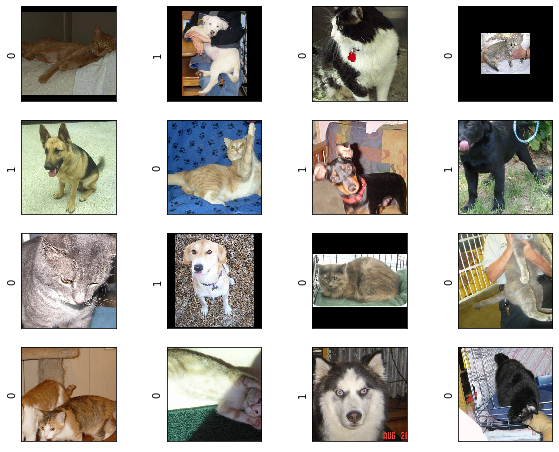

In [3]:
# 1=dog 0=cat
path = r'C:\Users\caeit\Desktop\binru7_1\train'
train_data = DogCat(path,train=True)
train_dataloader = DataLoader(train_data,batch_size=16,shuffle=True)
x,y = next(iter(train_dataloader))
mean = torch.Tensor([0.485, 0.456, 0.406])
std = torch.Tensor([0.229, 0.224, 0.225])

plt.figure(figsize=(10,8))
for j,i in enumerate(x):
    i = torch.transpose(i,2, 0)
    i = torch.transpose(i,0, 1)
    plt.subplot(4,4,j+1)
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(y.data.numpy()[j])
    plt.imshow(i*std+mean)

# 输入是(N,3,299,299)

In [4]:
x.shape

torch.Size([16, 3, 299, 299])

# inception-v3有两个输出
* primary output和auxiliary output，一般只用到primary output

In [5]:
model = inception_v3(pretrained=True)
model.aux_logits = False
model.fc = nn.Linear(2048,2)

In [6]:
model = model.cuda()
summary(model,(3,299,299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
           Conv2d-10           [-1, 80, 73, 73]           5,120
      BatchNorm2d-11           [-1, 80, 73, 73]             160
      BasicConv2d-12           [-1, 80, 73, 73]               0
           Conv2d-13          [-1, 192, 71, 71]         138,240
      BatchNorm2d-14          [-1, 192,

In [7]:
cost = torch.nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.SGD(model.parameters(),lr=1e-4,momentum=0.9)

start = datetime.datetime.now()
for i in range(20):
        correct = 0.0
        total = 25000
        running_loss = 0.0
        accuracy = 0.0
        print('-----epoch', i+1, '-----')
        for num, image in enumerate(train_dataloader):
            x_train, y_train = image
            x_train = x_train.cuda()
            y_train = y_train.cuda()
            optimizer.zero_grad()
            output = model(x_train)
            loss = cost(output, y_train)
            _, predicted = torch.max(output, 1)
            correct += (predicted == y_train).sum().item()
            #print(correct)
            if num%100 == 0:
                print(num*16, '/ 25000', 'loss:', running_loss, ',accuracy:{}%'.format((100*correct/25000)),'correct:%s'%correct)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print('-----------Epoch:', i+1, ', one_epoch_loss:', running_loss, '-----------',',accuracy:%f'%(100*correct/25000))
print(datetime.datetime.now()-start)
torch.save(model, '../fine_tuning_20_epoch_dog_cat_inceptionv3.pkl')

-----epoch 1 -----
0 / 25000 loss: 0.0 ,accuracy:0.032% correct:8.0
1600 / 25000 loss: 56.11834666132927 ,accuracy:4.988% correct:1247.0
3200 / 25000 loss: 92.13616542518139 ,accuracy:10.964% correct:2741.0
4800 / 25000 loss: 120.06789766252041 ,accuracy:16.956% correct:4239.0
6400 / 25000 loss: 142.2266068160534 ,accuracy:22.972% correct:5743.0
8000 / 25000 loss: 159.70372477173805 ,accuracy:29.08% correct:7270.0
9600 / 25000 loss: 175.61172479763627 ,accuracy:35.208% correct:8802.0
11200 / 25000 loss: 188.89505952969193 ,accuracy:41.372% correct:10343.0
12800 / 25000 loss: 201.95605209842324 ,accuracy:47.584% correct:11896.0
14400 / 25000 loss: 213.6579469256103 ,accuracy:53.756% correct:13439.0
16000 / 25000 loss: 225.39430313184857 ,accuracy:59.896% correct:14974.0
17600 / 25000 loss: 236.18750283494592 ,accuracy:66.064% correct:16516.0
19200 / 25000 loss: 246.29968172684312 ,accuracy:72.232% correct:18058.0
20800 / 25000 loss: 256.18573793023825 ,accuracy:78.4% correct:19600.0
224

19200 / 25000 loss: 27.119411608204246 ,accuracy:76.392% correct:19098.0
20800 / 25000 loss: 29.247342482209206 ,accuracy:82.736% correct:20684.0
22400 / 25000 loss: 32.60504706762731 ,accuracy:89.08% correct:22270.0
24000 / 25000 loss: 34.56375654414296 ,accuracy:95.444% correct:23861.0
-----------Epoch: 7 , one_epoch_loss: 35.506904289126396 ----------- ,accuracy:99.368000
-----epoch 8 -----
0 / 25000 loss: 0.0 ,accuracy:0.064% correct:16.0
1600 / 25000 loss: 1.327188840135932 ,accuracy:6.428% correct:1607.0
3200 / 25000 loss: 3.5773030687123537 ,accuracy:12.784% correct:3196.0
4800 / 25000 loss: 5.399352891370654 ,accuracy:19.144% correct:4786.0
6400 / 25000 loss: 7.2661714013665915 ,accuracy:25.52% correct:6380.0
8000 / 25000 loss: 8.67927611246705 ,accuracy:31.892% correct:7973.0
9600 / 25000 loss: 11.222760528326035 ,accuracy:38.24% correct:9560.0
11200 / 25000 loss: 12.659114832058549 ,accuracy:44.616% correct:11154.0
12800 / 25000 loss: 14.236112104728818 ,accuracy:50.976% corr

11200 / 25000 loss: 5.436188695952296 ,accuracy:44.764% correct:11191.0
12800 / 25000 loss: 5.790790660306811 ,accuracy:51.16% correct:12790.0
14400 / 25000 loss: 6.221035065129399 ,accuracy:57.552% correct:14388.0
16000 / 25000 loss: 6.5100799780339 ,accuracy:63.952% correct:15988.0
17600 / 25000 loss: 6.913582561537623 ,accuracy:70.348% correct:17587.0
19200 / 25000 loss: 7.645607152953744 ,accuracy:76.74% correct:19185.0
20800 / 25000 loss: 7.923068160191178 ,accuracy:83.14% correct:20785.0
22400 / 25000 loss: 8.327896758913994 ,accuracy:89.536% correct:22384.0
24000 / 25000 loss: 8.774496981874108 ,accuracy:95.932% correct:23983.0
-----------Epoch: 14 , one_epoch_loss: 9.149377493187785 ----------- ,accuracy:99.864000
-----epoch 15 -----
0 / 25000 loss: 0.0 ,accuracy:0.064% correct:16.0
1600 / 25000 loss: 0.6201520767062902 ,accuracy:6.452% correct:1613.0
3200 / 25000 loss: 1.2372402530163527 ,accuracy:12.844% correct:3211.0
4800 / 25000 loss: 2.091943457722664 ,accuracy:19.228% co

C:\Users\caeit\.conda\envs\pytorch_env\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Inception3. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\caeit\.conda\envs\pytorch_env\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BasicConv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\caeit\.conda\envs\pytorch_env\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\caeit\.conda\envs\pytorch_env\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading

In [8]:
model = torch.load(r'C:\Users\caeit\Desktop\fine_tuning_20_epoch_dog_cat_inceptionv3.pkl')
model = model.cuda()

path = r'C:\Users\caeit\Desktop\binru7_1\test1'
test_data = DogCat(path,train=False,test=True)
test_dataloader = DataLoader(test_data,batch_size=16,shuffle=False,num_workers=0)

result = []
start = datetime.datetime.now()
for num, image in enumerate(test_dataloader):
    x_train, y_train = image
    x_train = x_train.cuda()
    y_train = y_train.cuda()

    output = model(x_train)

    _, predicted = torch.max(output, 1)
    result.append(predicted)
print(datetime.datetime.now()-start)
result1 = []
for i in result:
    i = i.cpu()
    for j in i.data.numpy():
        result1.append(j)


for j,i in enumerate(result1):
    if i == 0:
        result1[j] = 0.05
    else:
        result1[j] = 0.95
np.savetxt("inceptionv3.csv", result1, delimiter=',')

0:02:00.082338
